In [5]:
# import libraries as necessary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from PIL import Image
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, fbeta_score, balanced_accuracy_score, make_scorer, confusion_matrix
from scipy.stats import randint, uniform
import xgboost as xgb
import seaborn as sns

In [2]:
data_folder = 'data/'

image_data = []
image_size = (64,64)

for label in os.listdir(data_folder):
    subfolder_path = os.path.join(data_folder, label)
    
    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            image = Image.open(image_path).convert('RGB').resize(image_size)
            image_array = np.array(image).flatten()
            image_data.append((image_array, label))  
df = pd.DataFrame(image_data, columns=['Image', 'Label'])


In [3]:
label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor':3}
df['Label_Int'] = df['Label'].map(label_map)

In [4]:
X = np.stack(df['Image'].values)
y = df['Label_Int'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=6740)

In [25]:
param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

balanced_acc_scorer = make_scorer(balanced_accuracy_score)
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [26]:
rf = RandomForestClassifier(random_state=6740)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20, 
    scoring={'balanced_accuracy': balanced_acc_scorer, 'f2_score': f2_scorer},
    refit='balanced_accuracy', 
    cv=5,  
    random_state=6740,
    n_jobs=-1  
)

random_search.fit(X_train, y_train)


Best Parameters: {'max_depth': 32, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 189}


In [27]:
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
y_pred = best_rf.predict(X_test)

Best Parameters: {'max_depth': 32, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 189}


In [28]:
# rf = RandomForestClassifier( random_state=6740, max_depth = 32, max_features = None, min_samples_leaf = 1, min_samples_split = 16, n_estimators = 189)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)

In [29]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Random Forest Balanced Accuracy: {balanced_acc * 100:.2f}%")
f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
print(f"Random Forest F2 Score: {f2_score:.2f}")

Random Forest Balanced Accuracy: 85.82%
Random Forest F2 Score: 0.86


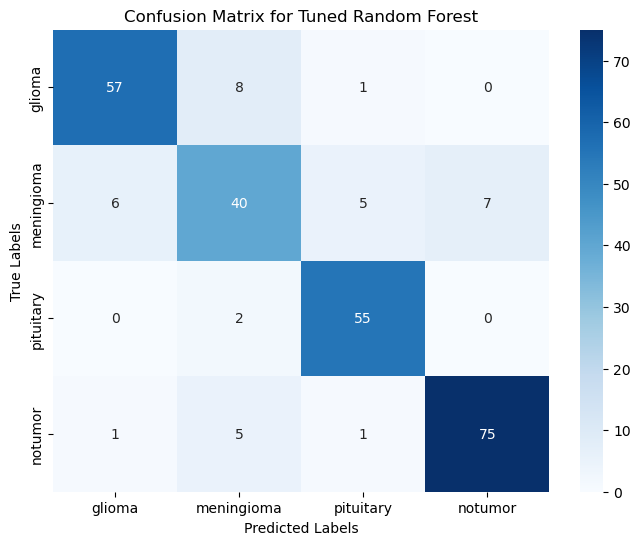

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Tuned Random Forest')
plt.show()

In [7]:
param_grid_xgb = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 10)
}

balanced_acc_scorer = make_scorer(balanced_accuracy_score)
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

xgb_mod = xgb.XGBClassifier(random_state=6740, use_label_encoder=False, eval_metric='mlogloss')
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_mod,
    param_distributions=param_grid_xgb,
    n_iter=20,  
    scoring={'balanced_accuracy': balanced_acc_scorer, 'f2_score': f2_scorer},
    refit='balanced_accuracy', 
    cv=5,  
    random_state=6740,
    n_jobs=-1
)

In [8]:
random_search_xgb.fit(X_train, y_train)

# Get the best parameters and model
best_xgb = random_search_xgb.best_estimator_
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)
# Best Parameters for XGBoost: {'colsample_bytree': 0.5697746448442176, 'gamma': 0.4990624726316001, 'learning_rate': 0.07728150041691052, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 64, 'subsample': 0.7359053918890734}

Best Parameters for XGBoost: {'colsample_bytree': 0.5697746448442176, 'gamma': 0.4990624726316001, 'learning_rate': 0.07728150041691052, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 64, 'subsample': 0.7359053918890734}


In [9]:
y_pred_xgb = best_xgb.predict(X_test)
balanced_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
f2_score_xgb = fbeta_score(y_test, y_pred_xgb, beta=2, average='weighted')

print(f"Tuned XGBoost Balanced Accuracy: {balanced_acc_xgb * 100:.2f}%")
print(f"Tuned XGBoost F2 Score: {f2_score_xgb:.2f}")

Tuned XGBoost Balanced Accuracy: 85.64%
Tuned XGBoost F2 Score: 0.86


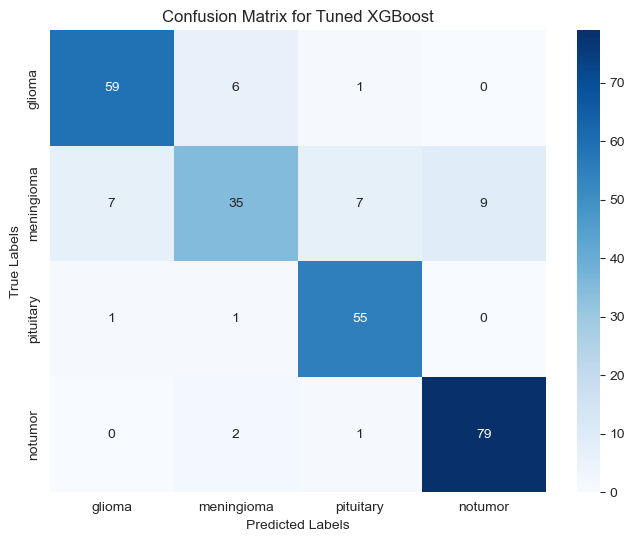

In [10]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Tuned XGBoost')
plt.show()